# Save/Retrieve workspace

In [361]:
path_workspace_fodler = "./save_workspace"
os.makedirs(path_workspace_fodler, exist_ok=True)
path_worskpace = os.path.join(path_workspace_fodler, "5.main_vs_contrast.pkl")

## Save

In [362]:
#  # To save the workspace
# import pickle

# # Example dictionary of variables to save
# variables_to_save = {
#     'var1': true_data,  # The pandas DataFrame
#     'var2': main_data,  # The pandas DataFrame
#     'var3': contrast_1,  # The pandas DataFrame
#     'var4': contrast_2,
#     'var4': columns_needed
# }

# # Save the dictionary to a file
# with open(path_worskpace, 'wb') as f:
#     pickle.dump(variables_to_save, f)

## Retrieve

In [ ]:
# # To retrieve the workspace
# import pickle

# # Load the saved variables
# with open(path_worskpace, 'rb') as f:
#     loaded_variables = pickle.load(f)

# # Retrieve your variables
# true_data = loaded_variables['var1']
# main_data = loaded_variables['var2']
# contrast_1 = loaded_variables['var3']
# contrast_2 = loaded_variables['var4']
# columns_needed = loaded_variables['var5']

# Code

In [358]:
import pandas as pd
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import os

## Prepare data

- `true_data`= the elements that passed the previous thest
- `main_data`=  Consensus+LmSIDER2A|B matched with LmSIDER and evalue $\leq 10^{-3}$
- `contrast_1` = Consensus+LmSIDER2A|B matched with LmSIDER and evalue $> 10^{-3}$
- `contrast_2` = Consensus+LmSIDER2A|B NOT matched with LmSIDER


### Prepare true data

In [302]:
# Prepare "true_data"
path_genome = "./data/L_infantum/dict/TriTrypDB-67_LinfantumJPCM5_Genome.fasta"
pre_true_data = pd.read_csv("./data/consensus+LmSIDER2A+B/positives_testing_elements.csv", sep=",", header=0)
print(pre_true_data.head(2))

    sseqid  sstart   send sstrand  \
0  LinJ.01       1   1000    plus   
1  LinJ.01   24093  25080    plus   

                                                sseq  
0  ACACCAGTACACCAGTACACCAGTACACCAGTACACCAGTACACCA...  
1  GGGGGAGGCGGGGGAGGCGGGGGGCACGCACCTCCATGCGTGGCAT...  


In [320]:
def fasta_creator(csv_input, output_path):
    matrix = []
    for index, row in csv_input.iterrows():
        rec = SeqRecord(Seq(row["sseq"]), 
                        id = f"Seq_{index}_{row['sseqid']}",
                        description = "Leishmania infantum"
                        )
        matrix.append(rec)
    SeqIO.write(matrix, output_path, "fasta")

def blastn_blaster(query_path, dict_path):
    cmd = "blastn -word_size 11 -query " \
        + query_path + " -db " \
        + dict_path \
        + " -outfmt '10 qseqid sseqid pident qstart qend sstart send evalue bitscore length qlen qcovs slen'"
    data = subprocess.run(cmd, shell=True, capture_output=True, text=True, universal_newlines=True, executable='/usr/bin/bash')  # Important the E value
    data = data.stdout
    data = pd.DataFrame([x.split(",") for x in data.split("\n") if x])
    if not data.empty:  # If the dataframe is not empty
        data.columns = ["qseqid", "sseqid", "pident", "qstart", "qend", "sstart", "send", "evalue", "bitscore", "length", "qlen", "qcovs", "slen"]
        data[['pident',  'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'length', 'qlen', 'qcovs', 'slen']] = data[['pident',  'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'length', 'qlen', 'qcovs', 'slen']].apply(pd.to_numeric)
    else:  # If the dataframe is empty
        data = pd.DataFrame(columns=["qseqid", "sseqid", "pident", "qstart", "qend", "sstart", "send", "evalue", "bitscore", "length", "qlen", "qcovs", "slen"])  # Create an empty dataframe
    return data 

def df_blasting_whole(data_input, genome_path):  # version with csv
    whole_df = pd.DataFrame()
    for count, row in data_input.iterrows():
        name_id = f"Seq_{count}_{row["sseqid"]}"
        query = f"<(echo -e '>{name_id}\n{row["sseq"]}')"
        data = blastn_blaster(query_path=query, dict_path=genome_path)
        data.sort_values(by="evalue", ascending=True, inplace=True)
        if not data.empty:
            whole_df = pd.concat([whole_df, data], ignore_index=True)
        else:
            continue
    whole_df.sort_values(by="evalue", ascending=True, inplace=True)
    return whole_df

In [321]:
true_data = df_blasting_whole(data_input=pre_true_data, genome_path=path_genome)
true_data.to_csv("./data/consensus+LmSIDER2A+B/neg_dat_filter_decider/TP_positive_whole.csv", sep=",", header=True)

In [286]:
# Load data
true_data = pd.read_csv("./data/consensus+LmSIDER2A+B/neg_dat_filter_decider/TP_positive_whole.csv", sep=",", header=0)
main_data = pd.read_csv("./data/consensus+LmSIDER2A+B/neg_dat_filter_decider/main/whole.csv", sep=",", header=0)
contrast_1 = pd.read_csv("./data/consensus+LmSIDER2A+B/neg_dat_filter_decider/contrast/neg_data_LmSIDER2A+B_and_no_evalue/whole.csv", sep=",", header=0)
contrast_2 = pd.read_csv("./data/consensus+LmSIDER2A+B/neg_dat_filter_decider/contrast/neg_data_no_LmSIDER2A+B/whole.csv", sep=",", header=0)

In [324]:
# Check heads
print(true_data.head(2))
print(main_data.head(2))
print(contrast_1.head(2))
print(contrast_2.head(2))

          qseqid   sseqid   pident  qstart  qend  sstart  send        evalue  \
0  Seq_0_LinJ.01  LinJ.01  100.000       1  1000       1  1000  0.000000e+00   
1  Seq_0_LinJ.01  LinJ.31   98.765       1   162    1404  1565  2.800000e-77   

   bitscore  length  qlen  qcovs     slen  
0    1847.0    1000  1000    100   278267  
1     289.0     162  1000     16  1529246  
           qseqid   sseqid   pident  qstart  qend  sstart    send  evalue  \
0  Seq_11_LinJ.02  LinJ.02   97.194       1   392  268717  269108     0.0   
1  Seq_29_LinJ.04  LinJ.04  100.000       1   585  394441  395025     0.0   

   bitscore  length  qlen  qcovs    slen  
0     664.0     392   635    100  356299  
1    1081.0     585   585    100  466507  
            qseqid   sseqid  pident  qstart  qend  sstart    send  evalue  \
0  Seq_140_LinJ.12  LinJ.12   99.04     943  1567  419342  419966     0.0   
1  Seq_151_LinJ.12  LinJ.12   94.56    2019  2628  425032  425655     0.0   

   bitscore  length  qlen  qcovs  

In [326]:
# Check shapes
print(true_data.shape)
print(main_data.shape)
print(contrast_1.shape)
print(contrast_2.shape)

(1465886, 13)
(8607, 13)
(10711, 13)
(124745, 13)


In [327]:
# check types
print(true_data.dtypes)
print(main_data.dtypes)
print(contrast_1.dtypes)
print(contrast_2.dtypes)

qseqid       object
sseqid       object
pident      float64
qstart        int64
qend          int64
sstart        int64
send          int64
evalue      float64
bitscore    float64
length        int64
qlen          int64
qcovs         int64
slen          int64
dtype: object
qseqid       object
sseqid       object
pident      float64
qstart        int64
qend          int64
sstart        int64
send          int64
evalue      float64
bitscore    float64
length        int64
qlen          int64
qcovs         int64
slen          int64
dtype: object
qseqid       object
sseqid       object
pident      float64
qstart        int64
qend          int64
sstart        int64
send          int64
evalue      float64
bitscore    float64
length        int64
qlen          int64
qcovs         int64
slen          int64
dtype: object
qseqid       object
sseqid       object
pident      float64
qstart        int64
qend          int64
sstart        int64
send          int64
evalue      float64
bitscore    float6

In [328]:
# Get unique values in "qseqid"
print(true_data["qseqid"].nunique())
print(main_data["qseqid"].nunique())
print(contrast_1["qseqid"].nunique())
print(contrast_2["qseqid"].nunique())

2069
23
43
646


In [329]:
columns_needed = ['pident', 'evalue', 'bitscore', 'length', 'qcovs']

## 1) Data without more filtering

In [330]:
main_data.columns

Index(['qseqid', 'sseqid', 'pident', 'qstart', 'qend', 'sstart', 'send',
       'evalue', 'bitscore', 'length', 'qlen', 'qcovs', 'slen'],
      dtype='object')

In [331]:
for i, column in enumerate(columns_needed):
    row, col = divmod(i, 3)
    print(row, col)

0 0
0 1
0 2
1 0
1 1


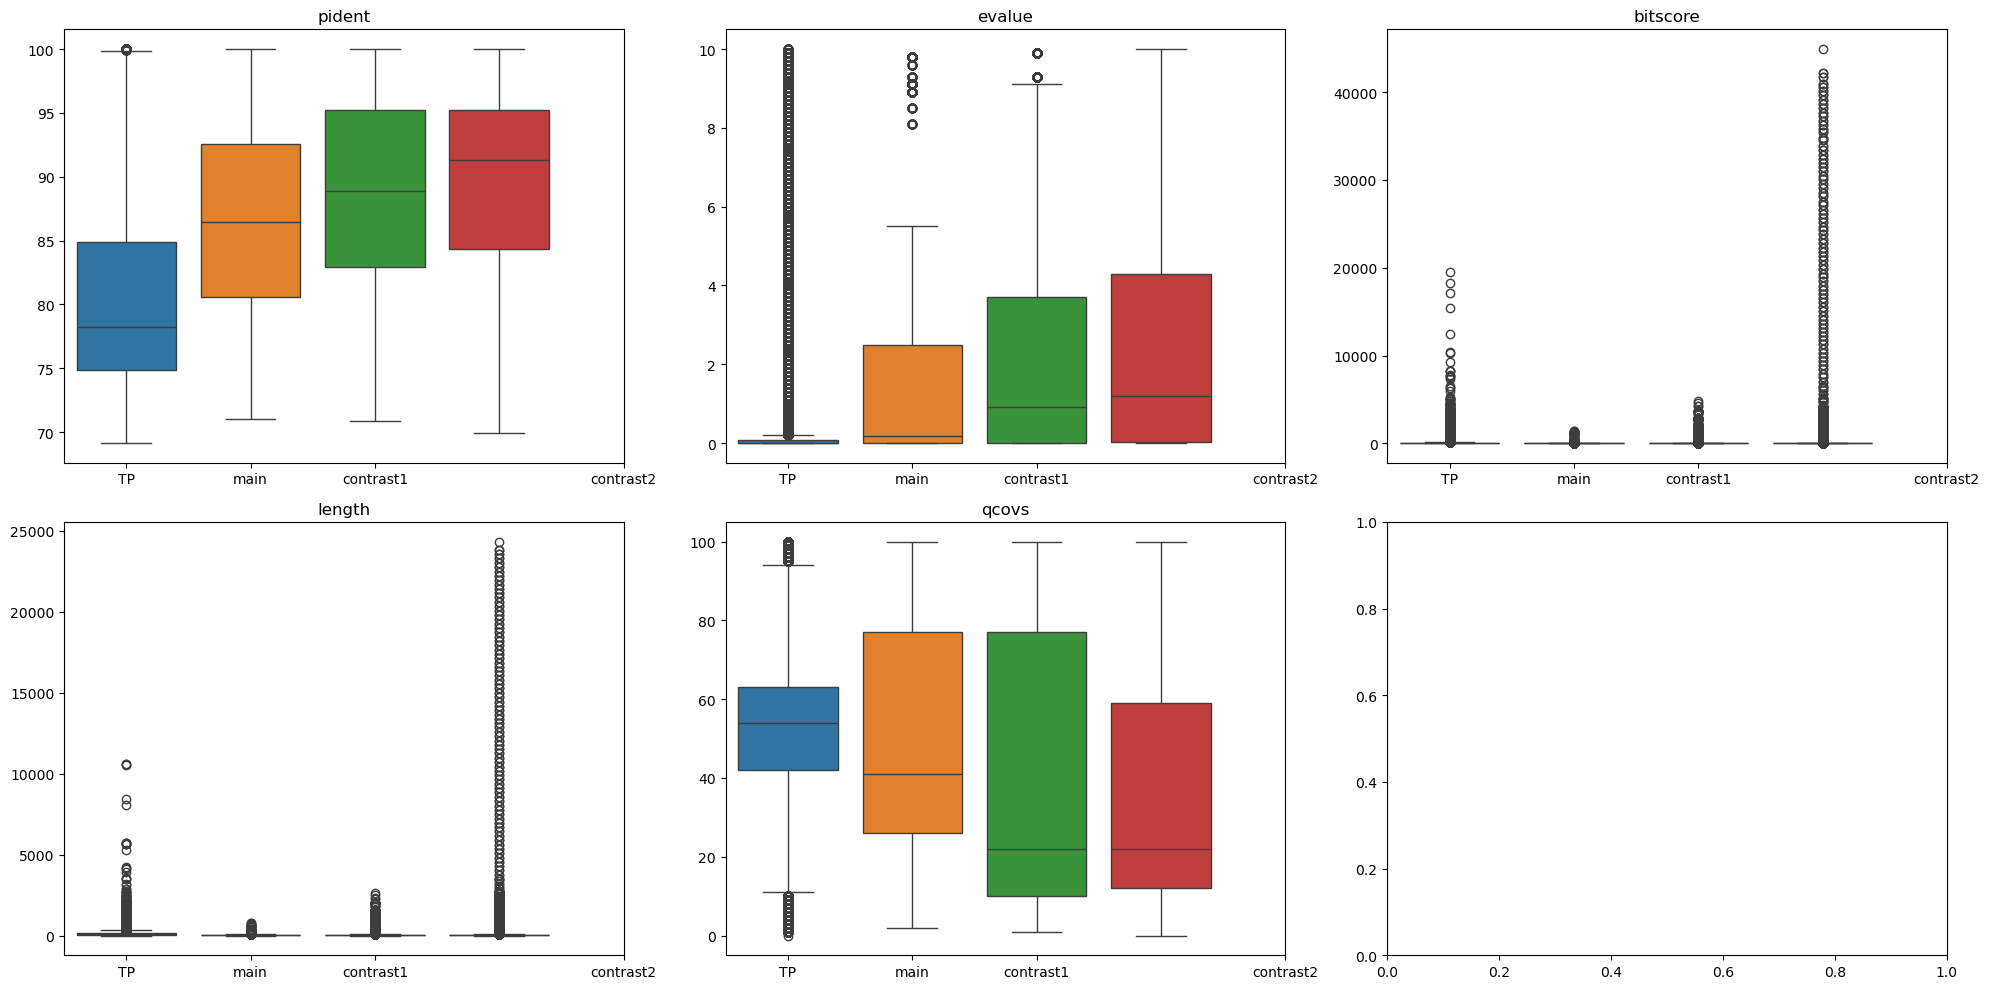

In [341]:
# Make boxplot in each data same for the columns in columns_needed
columns_needed = ['pident', 'evalue', 'bitscore', 'length', 'qcovs']
data0, data1, data2, data3 = true_data, main_data, contrast_1, contrast_2
fig, ax = plt.subplots(2,3, figsize=(20,10))

for i, column in enumerate(columns_needed):
    row, col = divmod(i, 3)  # Calculate row and column indices
    column_data = pd.concat([data0[column], data1[column], data2[column], data3[column]], axis=1)
    column_data.columns = ['TP', 'main', 'contrast1', 'contrast2']
    sns.boxplot(data=column_data, ax=ax[row, col])
    ax[row, col].set_title(column)
    ax[row, col].set_xticks([0, 1, 2, 4])
    ax[row, col].set_xticklabels(['TP', 'main', 'contrast1', 'contrast2'])

plt.tight_layout()
plt.show()
plt.close()

In [353]:
# Compare pident
pident_c = pd.concat([true_data["pident"], main_data["pident"], contrast_1["pident"], contrast_2["pident"]], axis=1)
pident_c.columns = ["TP", "main", "contrast1", "contrast2"]
pident_c.describe()

,TP,main,contrast1,contrast2
count,1.465886e+06,8607.000000,10711.000000,124745.000000
mean,8.068736e+01,86.919267,88.736326,89.885169
std,7.630203e+00,7.612015,7.919744,7.754775
min,6.913400e+01,71.023000,70.854000,69.921000
25%,7.482500e+01,80.590000,82.927000,84.375000
50%,7.821800e+01,86.486000,88.889000,91.304000
75%,8.484800e+01,92.593000,95.238000,95.238000
max,1.000000e+02,100.000000,100.000000,100.000000


In [354]:
# Compare evalue
evalue_c = pd.concat([true_data["evalue"], main_data["evalue"], contrast_1["evalue"], contrast_2["evalue"]], axis=1)
evalue_c.columns = ["TP", "main", "contrast1", "contrast2"]
evalue_c.describe()

,TP,main,contrast1,contrast2
count,1.465886e+06,8607.000000,10711.000000,124745.000000
mean,6.081378e-01,1.593199,2.343422,2.531836
std,1.549818e+00,2.674972,2.904754,2.926211
min,0.000000e+00,0.000000,0.000000,0.000000
25%,2.270000e-12,0.001000,0.008000,0.015000
50%,9.540000e-06,0.190000,0.920000,1.200000
75%,8.400000e-02,2.500000,3.700000,4.300000
max,1.000000e+01,9.800000,9.900000,10.000000


In [355]:
# compare "bitescore"
bitscore_c = pd.concat([true_data["bitscore"], main_data["bitscore"], contrast_1["bitscore"], contrast_2["bitscore"]], axis=1)
bitscore_c.columns = ["TP", "main", "contrast1", "contrast2"]
bitscore_c.describe()

,TP,main,contrast1,contrast2
count,1.465886e+06,8607.000000,10711.000000,124745.000000
mean,6.744487e+01,42.844952,75.910485,108.687024
std,1.018996e+02,54.942904,267.383593,960.835477
min,2.880000e+01,28.800000,28.800000,28.800000
25%,3.810000e+01,32.500000,32.500000,32.500000
50%,5.100000e+01,36.200000,34.400000,34.400000
75%,7.310000e+01,43.600000,39.900000,39.900000
max,1.947500e+04,1423.000000,4861.000000,44919.000000


In [356]:
# Compare "length"
length_c = pd.concat([true_data["length"], main_data["length"], contrast_1["length"], contrast_2["length"]], axis=1)
length_c.columns = ["TP", "main", "contrast1", "contrast2"]
length_c.describe()

,TP,main,contrast1,contrast2
count,1.465886e+06,8607.000000,10711.000000,124745.000000
mean,1.301223e+02,47.149297,65.926617,84.519051
std,1.219879e+02,42.493640,165.734396,553.667505
min,1.500000e+01,15.000000,15.000000,15.000000
25%,4.400000e+01,23.000000,21.000000,20.000000
50%,9.400000e+01,36.000000,30.000000,26.000000
75%,1.750000e+02,56.000000,54.000000,46.000000
max,1.060300e+04,770.000000,2632.000000,24324.000000


In [357]:
# Compare qcovs
qcovs_c = pd.concat([true_data["qcovs"], main_data["qcovs"], contrast_1["qcovs"], contrast_2["qcovs"]], axis=1)
qcovs_c.columns = ["TP", "main", "contrast1", "contrast2"]
qcovs_c.describe()

,TP,main,contrast1,contrast2
count,1.465886e+06,8607.000000,10711.000000,124745.000000
mean,5.396663e+01,49.368886,39.148912,37.392072
std,1.974402e+01,29.434550,35.795690,33.629638
min,0.000000e+00,2.000000,1.000000,0.000000
25%,4.200000e+01,26.000000,10.000000,12.000000
50%,5.400000e+01,41.000000,22.000000,22.000000
75%,6.300000e+01,77.000000,77.000000,59.000000
max,1.000000e+02,100.000000,100.000000,100.000000


## 2) First filter

In [363]:
# Filter for "evalue =< 0"
# 6.835000e-17 last one that maintained the 23 elements
num_f = 0.001000
true_data_v2 = true_data[true_data["evalue"] <= num_f].copy()
main_data_v2 = main_data[main_data["evalue"] <= num_f].copy()
contrast_1_v2= contrast_1[contrast_1["evalue"] <= num_f].copy()
contrast_2_v2 = contrast_2[contrast_2["evalue"] <= num_f].copy()

In [364]:
# check shape after filtering
print(true_data_v2.shape)
print(main_data_v2.shape)
print(contrast_1_v2.shape)
print(contrast_2_v2.shape)

(915737, 13)
(2280, 13)
(2161, 13)
(25240, 13)


In [366]:
# Get unique values in "qseqid"
print(true_data_v2["qseqid"].nunique())
print(main_data_v2["qseqid"].nunique())
print(contrast_1_v2["qseqid"].nunique())
print(contrast_2_v2["qseqid"].nunique())

2069
23
43
646


In [367]:
def split_csv(file_path, split_ratio=0.5, output_file1='output_part1.csv', output_file2='output_part2.csv'):
    # Read the CSV file
    data = pd.read_csv(file_path)
    
    # Calculate the split index
    split_index = int(len(data) * split_ratio)
    
    # Split the data into two parts
    data_part1 = data.iloc[:split_index]
    data_part2 = data.iloc[split_index:]
    
    # Write each part to a new CSV file
    data_part1.to_csv(output_file1, index=False)
    data_part2.to_csv(output_file2, index=False)
    
    print(f"Data split into {output_file1} and {output_file2}")

# Example usage
file_path = './data/consensus+LmSIDER2A+B/neg_dat_filter_decider/TP_positive_whole.csv'
file_path_part1 = './data/consensus+LmSIDER2A+B/neg_dat_filter_decider/TP_positive_whole_part1.csv'
file_path_part2 = './data/consensus+LmSIDER2A+B/neg_dat_filter_decider/TP_positive_whole_part2.csv'
split_csv(file_path, split_ratio=0.5, output_file1=file_path_part1, output_file2=file_path_part2)


Data split into ./data/consensus+LmSIDER2A+B/neg_dat_filter_decider/TP_positive_whole_part1.csv and ./data/consensus+LmSIDER2A+B/neg_dat_filter_decider/TP_positive_whole_part2.csv
